# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


## 1.1. Imports & constants

In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import contextily as ctx

# 2. Load data

## 2.1. Zones (TIGER)

In [4]:
zones = gpd.read_parquet('../data/zones/zones_2010.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


geoid      name       aland    awater  \
   <object>  <object>     <int64>   <int64>   
0     18083      Knox  1336514262  20755159   

                                            geometry     scale  
                                          <geometry>  <object>  
0  POLYGON ((-87.506221 38.733533, -87.506172 38....    COUNTY

## 2.2. Census (ACS)

In [5]:
acs = pd.read_csv('../data/acs/acs19.csv').astype({'geoid': str}).disp()

6,407 rows x 28 cols; Memory: 2.1 MiB


scale     geoid       popu         hh pop_density      m_age    p_minor  \
   <object>  <object>  <float64>  <float64>   <float64>  <float64>  <float64>   
0    COUNTY     18069    36359.0    14742.0    95.01872       40.7   0.159328   

    p_senior p_nonwhite    p_black p_nocollege   m_income      p_pov  \
   <float64>  <float64>  <float64>   <float64>  <float64>  <float64>   
0   0.168541   0.041503   0.009819    0.495064    28502.0   0.101441   

     p_pov50   p_pov150     p_snap p_unemploy p_noinsurance p_disabled  \
   <float64>  <float64>  <float64>  <float64>     <float64>  <float64>   
0   0.014131   0.133239   0.084588   0.027811      0.106346   0.892841   

  p_lowenglish p_singleparent   p_renter p_mobilehome    p_noveh m_vehperhh  \
     <float64>      <float64>  <float64>    <float64>  <float64>  <float64>   
0     0.106968       0.192825    0.23065     0.020586   0.047144   1.982024   

       p_wfh  p_transit  p_altmode  
   <float64>  <float64>  <float64>  
0   0.033737   0.001419   0.033155

## 2.3. POIs (SafeGraph)

In [6]:
pois = (gpd.read_parquet('../data/pois/sg_pois.parquet')
        .set_crs(CRS_DEG)).disp()

81,226 rows x 8 cols; Memory: 18.0 MiB; CRS: EPSG:4326


id    category         nhts_purpose essential  \
              <object>    <object>             <object>    <bool>   
0  222-225@63k-6hf-fvf  Food/Drink  Social/Recreational     False   

                    geometry   visits visitors  area_sqft  
                  <geometry>  <int32>  <int32>  <float64>  
0  POINT (-85.208 41.074036)      354      287     2883.0

## 2.4. Travel times
Distance/time between each OD pair

In [7]:
od = []
for f in Path('../data/distance').glob('*.csv'):
    scale, mode, day_type = f.stem.split('.')[0].split('__')
    if day_type == 'weekend': continue
    df = pd.read_csv(f).assign(scale=scale.upper(), mode=mode.upper())
    od.append(df.assign(time=df.time / 60)) # convert to minutes
od = pd.concat(od).reset_index(drop=True)
od = od.astype({'scale': CAT, 'mode': CAT}).disp()

7,620,668 rows x 8 cols; Memory: 312.5 MiB


src_geoid    trg_geoid       dist       time      ok      speed  \
       <int64>      <int64>  <float64>  <float64>  <bool>  <float64>   
0  18105001301  18105001402        NaN        NaN   False        NaN   

        scale        mode  
   <category>  <category>  
0       TRACT     TRANSIT

# 3. Accessibility measure
[Original E2SFCA paper](https://www.sciencedirect.com/science/article/pii/S1353829209000574?casa_token=R-O3z17sKz4AAAAA:BXZX0J2mjBUAl2Oj1YpRFlBkF03AwLcSVvW8g_Iun-9LQdKii14QdmkOpu8EDliHW_wTZ8Ddow)

## 3.1. Travel time weight functions

### 3.1.1. Driving
Cost impedance function for driving based on the E2SFCA formula in the project report.
$$ w(t) = \begin{cases} 1 & t\le 28\;\text{min} \\ \exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)} & t>28\;\text{min} \end{cases} $$

In [8]:
def get_cost_drive(time: pd.Series, vmin=28, vmax=60, sd=20):
    cost = np.exp(-0.5 * ((time - vmin) / sd) ** 2)
    cost.loc[time <= vmin] = 1
    cost.loc[time >= vmax] = 0
    return cost

### 3.1.2. Walking
Cost impedance function for walking, based on the WalkScore weight step function (**reference?**).

In [9]:
def get_cost_walk(time: pd.Series,
                  bin_start=(0, 5, 10, 15, 20, 25, 30),
                  weights=(1., .88, .60, .25, .075, .045, 0)):
    return pd.cut(time, bins=list(bin_start) + [np.inf],
                  labels=weights, right=False).astype(float)

## 3.2. POI importance weighting

In [10]:
def get_poi_weights(pois, method, log=True, eps=1e-6):
    """
    The method for weighting POIs (not every POI is created equal).
    Inputs:
        - pois: DataFrame containing info for each POI
        - method: One of the different ways of weighting POIs
        - log: Whether log-transform columns to reduce skewing of result
    Output:
        - the input DataFrame with an additional POI weights column
    """
    poi_cols = ['area_sqft', 'visits', 'visitors']
    pois = pois.fillna(0) # to ensure no POI weight is NaN
    if log:
        for col in poi_cols:
            pois[col] = np.log10(1 + pois[col])
    weights = {
        'COUNT': 1,
        'VISITS': pois['visits'],
        'VISITORS': pois['visitors'],
        'AREA': pois['area_sqft'],
        'AREA_X_VISITS': pois['area_sqft'] * pois['visits'],
        'VISIT_DENSITY': pois['visits'] / (pois['area_sqft'] + eps),
        'VISITOR_DENSITY': pois['visitors'] / (pois['area_sqft'] + eps)
    }[method]
    return pois.assign(weight=weights)

## 3.3. Impact of population at destination
This is the controversial inclusion of (weighted) population in the denominator of the attractiveness (facility ratio) in the E2SFCA calculation.

In [11]:
def get_popu_weights(zones, od):
    """
    Inputs:
        - zones: Zones containing population information
        - od: Table containing travel time cost for each OD pair
    """
    popu = zones.set_index('geoid')['popu'].reset_index()
    od = od.merge(popu, left_on='src_geoid', right_on='geoid')
    od['wtd_popu'] = od['cost'] * od['popu']
    weights = od.groupby('trg_geoid')['wtd_popu'].sum().rename_axis('geoid')
    return weights

## 3.4. Compute accessibility

In [12]:
def get_poi_access(scale: str, mode: str, tt_max: float,
                   zones=zones, acs=acs, pois=pois, od=od,
                   poi_weight_method='COUNT',
                   source_popu=True, target_popu=False):
    """
    Get POI accessibility using the gravity-like E2SFCA metric.
    Inputs:
        - scale: Scale of operation
        - mode: Travel mode (currently supports only DRIVE & WALK)
        - tt_thresh: Travel time threshold (minutes)
        - zones: Table of zones for all scales
        - acs: ACS data table for all zones having at least population
        - pois: Table of POIs containing at least POI category & other 
            attributes (such as area or visits) for computing weight
        - od: Table of travel time for all OD pairs
        - poi_weight_method: One of the methods used to weight POIs
        - source_popu: Whether divide the final accessibility of 
            a zone by its population
        - target_popu: Whether divide the destination zone's 
            attractiveness by its catchment population
    """
    # filter census & zone boundary data for the given scale
    acs = acs[acs['scale'] == scale][['geoid', 'popu']]
    zones = zones[zones['scale'] == scale][['geoid', 'geometry']]
    # get population for each zone
    zones = zones.merge(acs, on='geoid')
    # get weight of each POI
    pois = (get_poi_weights(pois, poi_weight_method)
            .rename(columns={'category': 'poi_kind', 'weight': 'poi_wt'})
            [['geometry', 'poi_kind', 'poi_wt']])
    # get attractiveness of each zone for each POI category
    attract = (zones.sjoin(pois).groupby(['geoid', 'poi_kind'])
               ['poi_wt'].sum().reset_index())
    # filter travel times for given mode, scale & travel time threshold
    od = od.query('scale=="{}" & mode=="{}" & time<={}'.format(
        scale, mode, tt_max)).reset_index(drop=True)
    # assign travel time-based cost to each OD pair for the given mode
    od['cost'] = {'DRIVE': get_cost_drive,
                  'WALK': get_cost_walk
                 }[mode](od['time'])
    od = od.astype({'src_geoid': str, 'trg_geoid': str})
    od = od[['src_geoid', 'trg_geoid', 'cost']]
    # if needed, update the destinations' attractiveness by 
    # dividing by the weighted population
    if target_popu:
        popu_wts = get_popu_weights(zones, od)
        attract = attract.merge(popu_wts, on='geoid')
        attract['poi_wt'] /= (attract.pop('wtd_popu') / 1e6)
    # accessibility = cost-weighted sum of destinations' attractiveness
    od = od.merge(attract, left_on='trg_geoid', right_on='geoid')
    od['access'] = od['poi_wt'] * od['cost']
    access = (od.groupby(['src_geoid', 'poi_kind'])['access']
              .sum().reset_index().rename(columns={'src_geoid': 'geoid'}))
    # if needed, compute accessibility per person in each zone
    if source_popu:
        access = access.merge(acs, on='geoid')
        access['access'] /= access.pop('popu')
    return access

xs = get_poi_access('BG', 'DRIVE', 30).disp()

52,859 rows x 3 cols; Memory: 7.2 MiB


geoid  poi_kind     access
       <object>  <object>  <float64>
0  180010301001      Care   0.188549

# 4. Visualize

In [13]:
def plot_map_poi_access(scale, mode, tt_thresh, poi_kind=None, zones=zones,
                        cmap='rainbow', dpi=120, vmin=None, vmax=None, **kwargs):
    xs = get_poi_access(scale, mode, tt_thresh, **kwargs)
    xs = zones[['geoid', 'geometry']].merge(xs, on='geoid')
    assert poi_kind in [None] + list(xs['poi_kind'].unique())
    if isinstance(poi_kind, str):
        xs = xs.query(f'poi_kind=="{poi_kind}"')
    cnty = zones.query('scale=="COUNTY"')
    title = 'Accessibility to {} POIs at {}\n scale within {} minutes by {}'.format(
        poi_kind if poi_kind else 'all', scale, tt_thresh, mode)
    ax = U.plot(size=(8, 16), dpi=dpi, axoff=1, title=title)
    xs.plot(ax=ax, column='access', cmap=cmap, legend=True,
            edgecolor='k', lw=0.1, vmin=vmin, vmax=vmax, legend_kwds=dict(
                shrink=0.4, label='POI accessibility'))
    cnty.plot(ax=ax, ec='k', lw=1, facecolor='none')

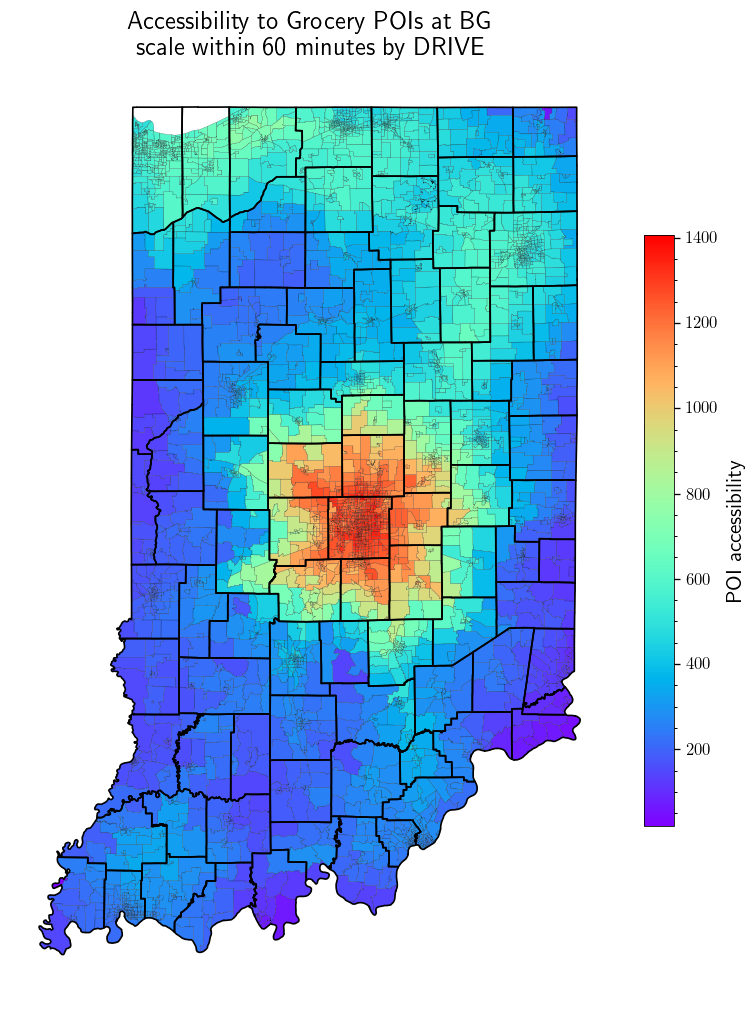

In [14]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Grocery', source_popu=False) # t=0:09

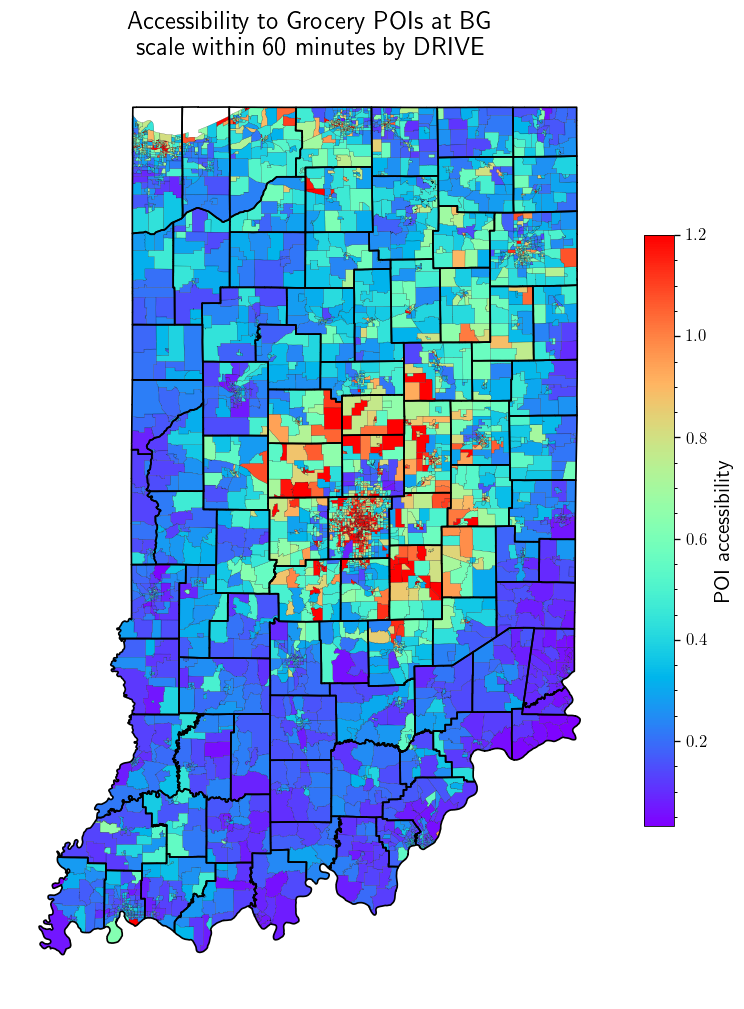

In [15]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Grocery', source_popu=True, vmax=1.2)

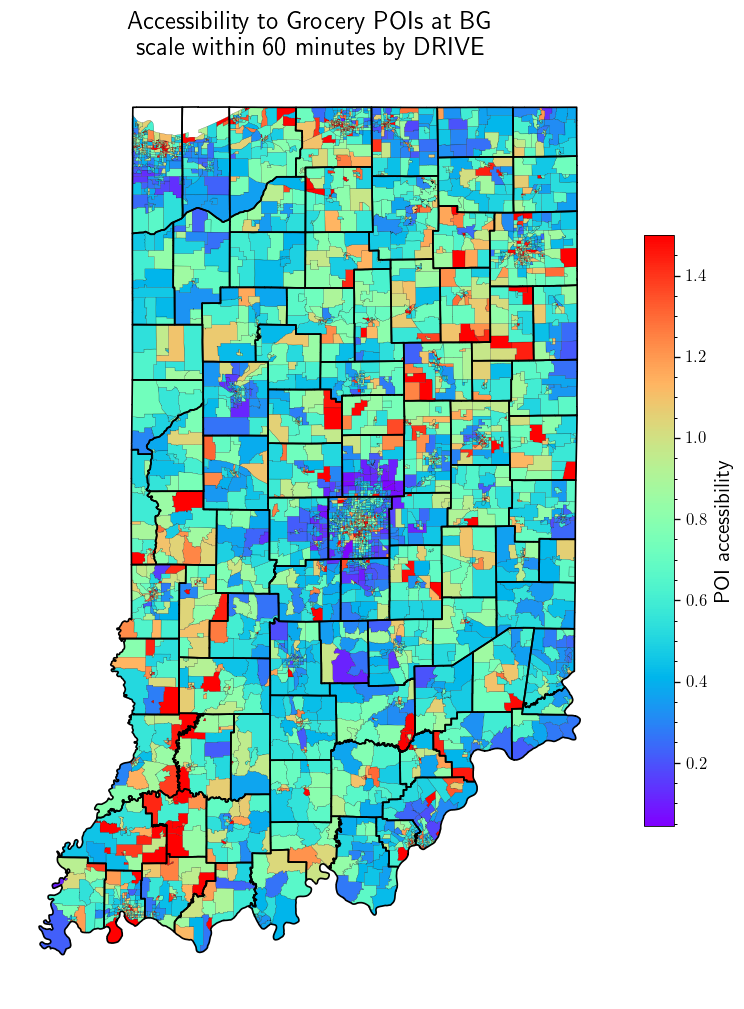

In [16]:
plot_map_poi_access('BG', 'DRIVE', 60, 'Grocery', vmax=1.5, target_popu=True)

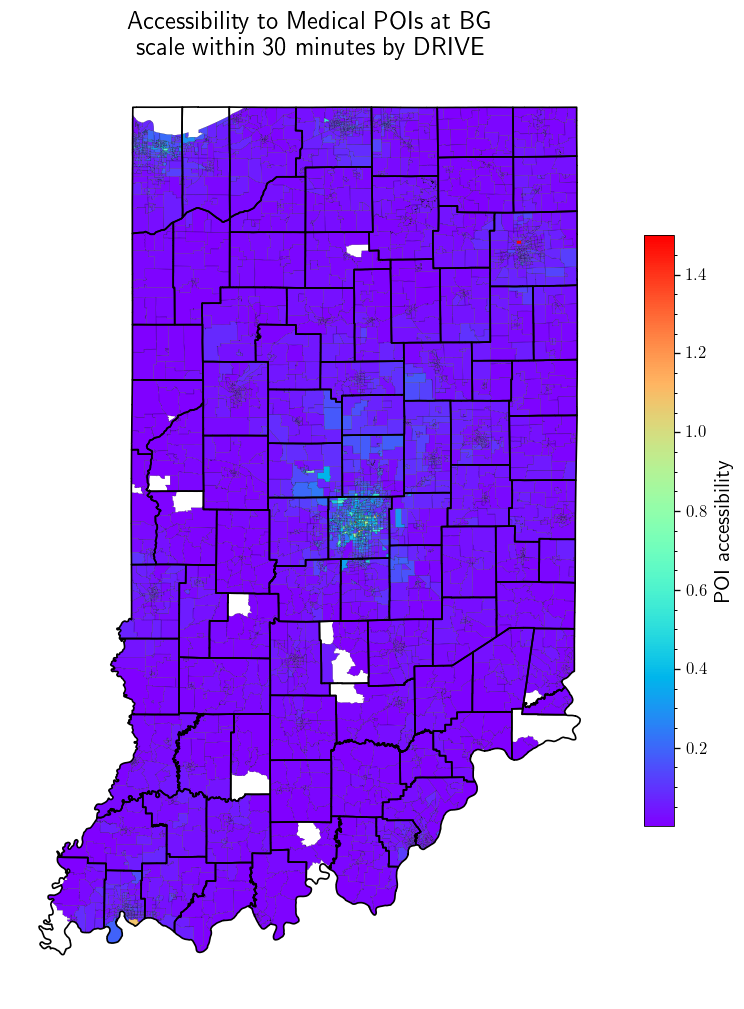

In [17]:
plot_map_poi_access('BG', 'DRIVE', 30, 'Medical', vmax=1.5, poi_weight_method='VISITS')

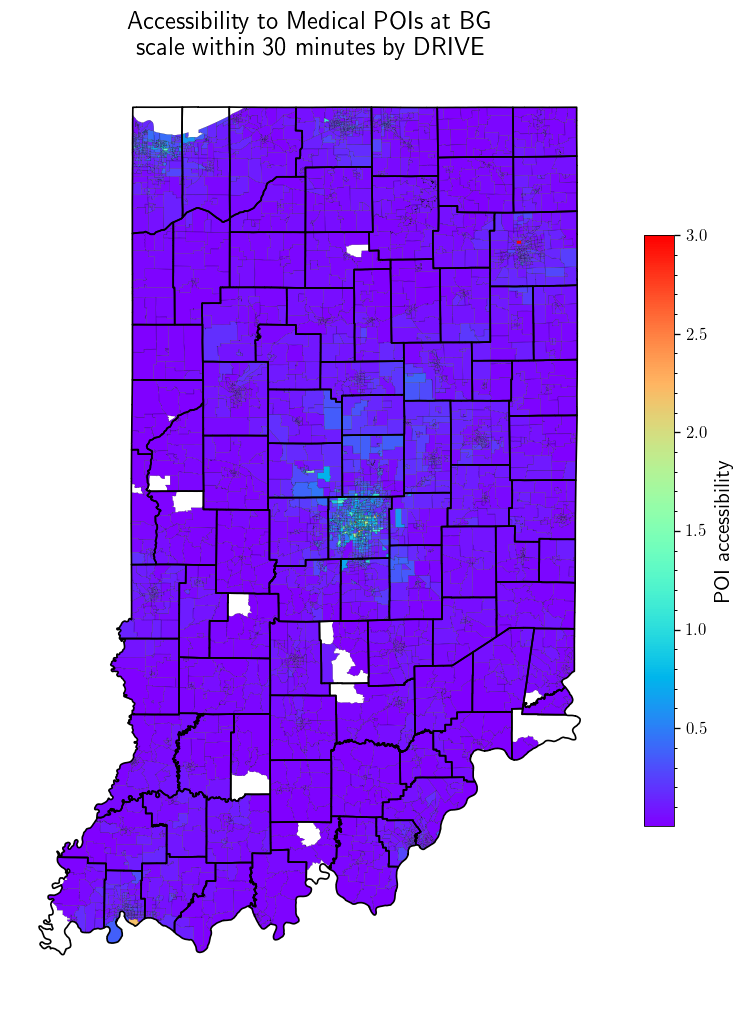

In [18]:
plot_map_poi_access('BG', 'DRIVE', 30, 'Medical', vmax=3, poi_weight_method='AREA')

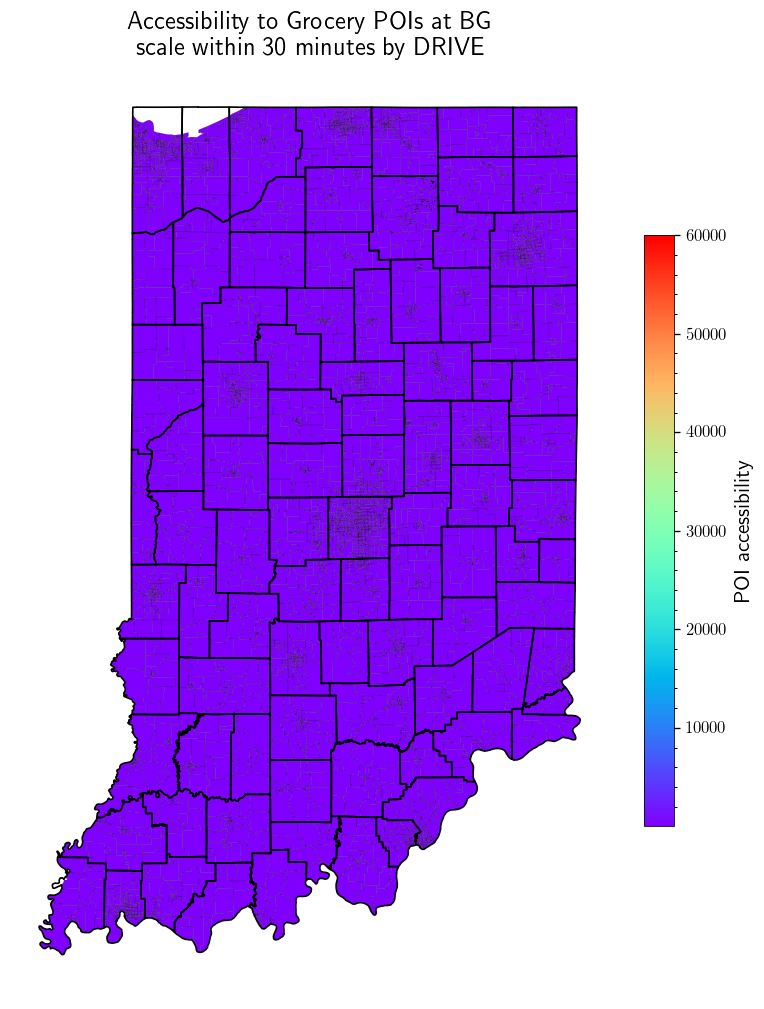

In [19]:
plot_map_poi_access('BG', 'DRIVE', 30, 'Grocery', vmax=6e4, poi_weight_method='VISIT_DENSITY')

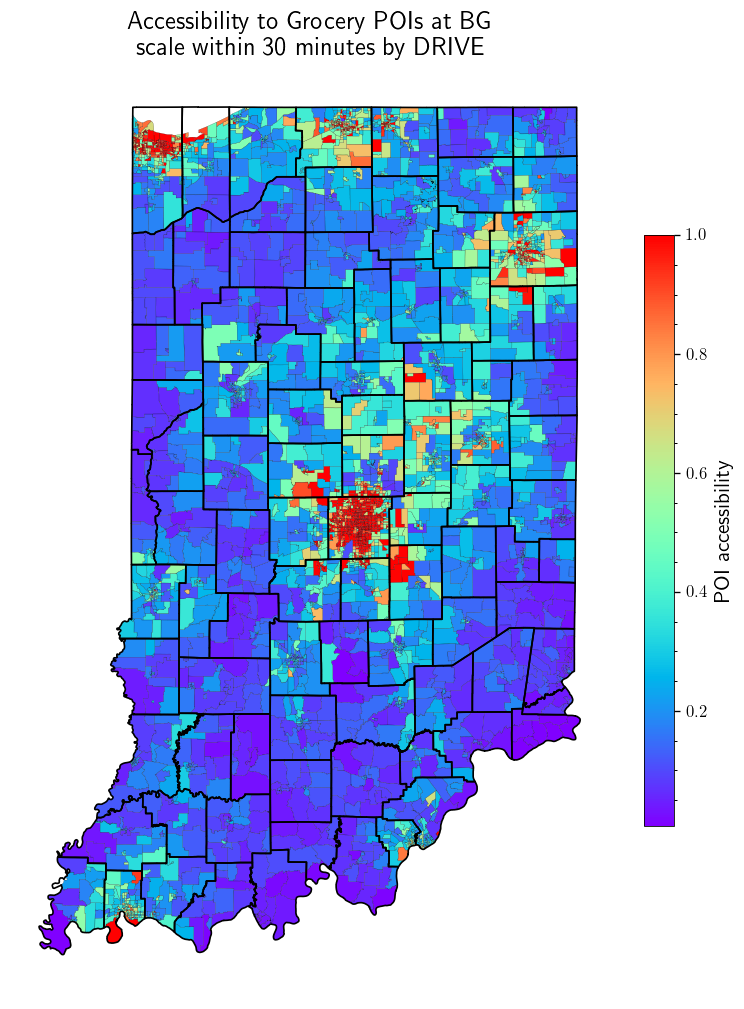

In [20]:
plot_map_poi_access('BG', 'DRIVE', 30, 'Grocery', vmax=1, poi_weight_method='VISITS')

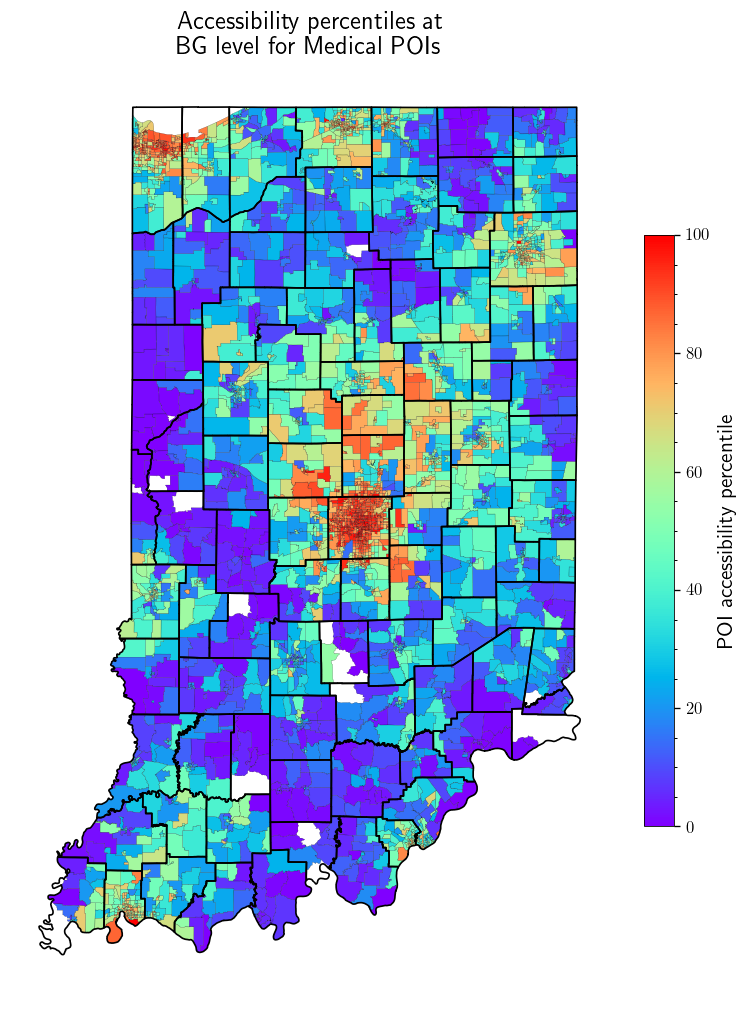

In [21]:
ax = U.plot(size=(8, 16), dpi=120, axoff=1, title='Accessibility percentiles at\nBG level for Medical POIs')
df = zones.merge(xs[xs.poi_kind=='Medical'].sort_values('access').reset_index(drop=True).assign(pctile=lambda df: df.index / len(df) * 100))
cnty = zones.query('scale=="COUNTY"')
df.plot(ax=ax, column='pctile', cmap='rainbow', legend=True, vmax=100,
        edgecolor='k', lw=0.1, legend_kwds=dict(
            shrink=0.4, label='POI accessibility percentile'))
cnty.plot(ax=ax, edgecolor='k', lw=1, facecolor='none');

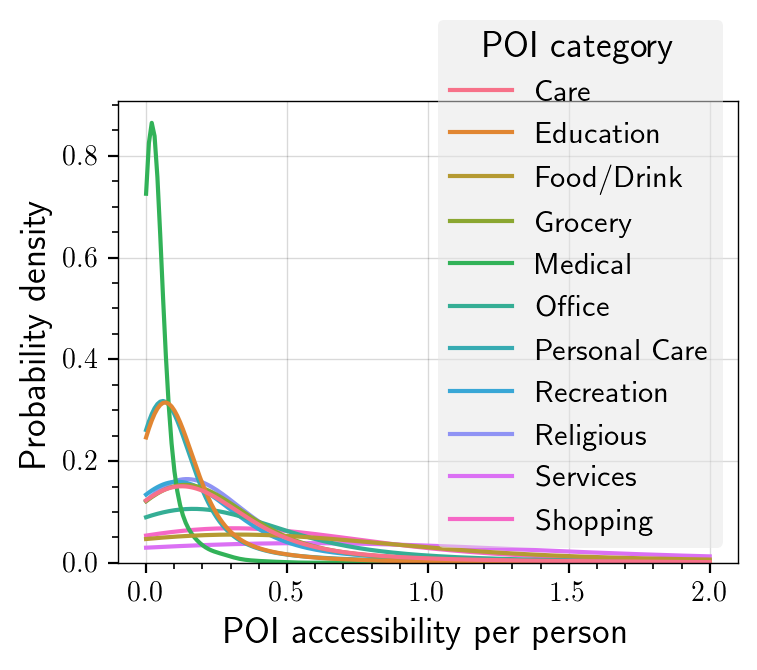

In [22]:
ax = U.plot(size=(4, 3), dpi=200)
title='Distribution of accessibility by POI kind'
sns.kdeplot(xs, x='access', hue='poi_kind', ax=ax, clip=(0, 2))
ax = U.plot(ax, xlab='POI accessibility per person', ylab='Probability density')
ax.get_legend().set_title('POI category');

In [23]:
# indy_cnty = cnty[cnty.name.isin(('Marion','Hamilton','Hendricks','Johnson','Madison','Hancock','Morgan','Boone','Shelby','Putnam','Brown'))].disp()
indy_cnty = zones.query('name == "Marion"').to_crs(CRS_M).disp()

1 rows x 6 cols; Memory: 0.0 MiB; CRS: EPSG:3857


geoid      name       aland    awater  \
    <object>  <object>     <int64>   <int64>   
86     18097    Marion  1026408097  17377675   

                                             geometry     scale  
                                           <geometry>  <object>  
86  POLYGON ((-9609832.152039 4825262.090051, -960...    COUNTY

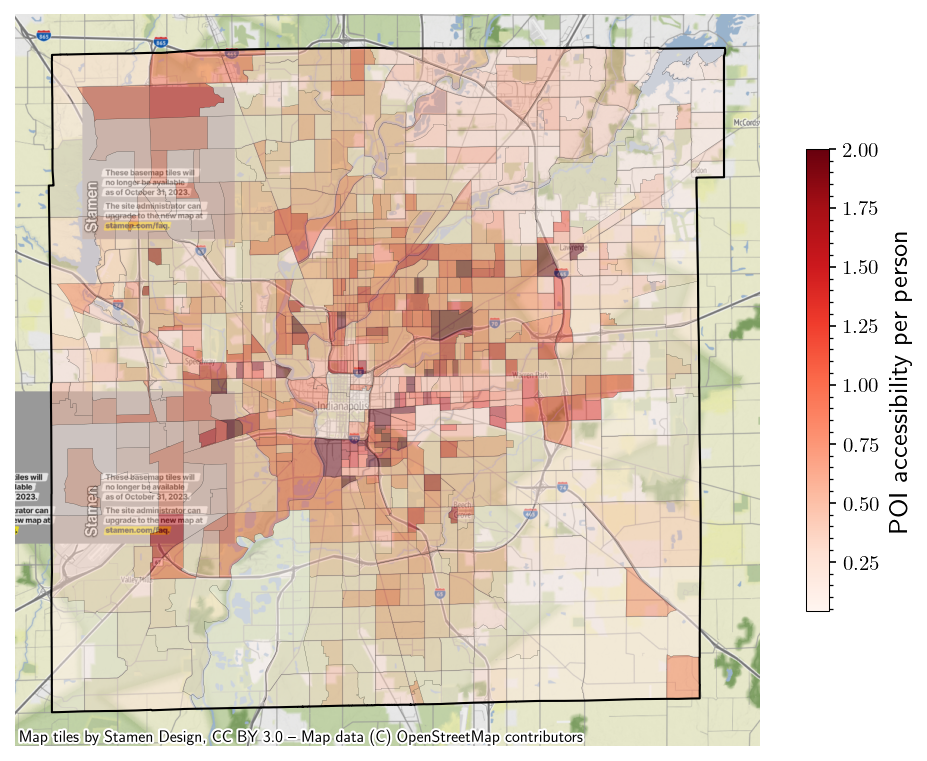

In [24]:
ax = U.plot(size=(8, 8), axoff=1)
indy_xs = (zones[['geoid','geometry']]
           .merge(xs.assign(cnty=xs.geoid.str[:5])
                  .query('poi_kind=="Grocery"')
                  .merge(indy_cnty['geoid'].rename('cnty')))
           .to_crs(CRS_M))
indy_xs.plot(ax=ax, column='access', cmap='Reds', legend=True,
            edgecolor='k', lw=0.1, vmax=2, alpha=0.5, legend_kwds=dict(
                shrink=0.5, label='POI accessibility per person'))
indy_cnty.plot(ax=ax, fc='none', ec='k', lw=1)
ctx.add_basemap(ax=ax, crs=CRS_M);

In [25]:
df = xs.merge(acs.assign(cnty=acs.geoid.str[:5]).merge(indy_cnty['geoid'].rename('cnty'))).query('poi_kind=="Grocery"')
# ax = U.plot(size=(5, 4), xlab='Median income (1,000 USD)', ylab='Access to grocery places')
# ax.scatter(df.inc_median/1e3, df.access.clip(0, 4), s=4, alpha=0.5);
df

geoid poi_kind    access scale    popu      hh  pop_density  \
3     180973101031  Grocery  0.181051    BG  2214.0   721.0   364.901570   
14    180973101032  Grocery  0.940841    BG   882.0   268.0   489.420042   
25    180973101033  Grocery  0.405616    BG  2046.0   708.0   901.612501   
36    180973101034  Grocery  0.279189    BG  2736.0   994.0   792.006785   
47    180973101041  Grocery  1.054043    BG   626.0   422.0  1105.554018   
...            ...      ...       ...   ...     ...     ...          ...   
6900  180973909002  Grocery  1.765168    BG   473.0   252.0  4651.848779   
6911  180973909003  Grocery  0.866137    BG   972.0   428.0  7130.184333   
6922  180973910001  Grocery  0.319475    BG  2801.0  1541.0  6454.432919   
6933  180973910002  Grocery  0.902609    BG   915.0   250.0  1235.751584   
6944  180973910003  Grocery  0.328320    BG  2607.0  1499.0  2109.156298   

      m_age   p_minor  p_senior  p_nonwhite   p_black  p_nocollege  m_income  \
3      38.2  0.158085  0.079042    0.438121  0.305330          NaN       NaN   
14     51.3  0.218821  0.221088    0.026077  0.000000          NaN       NaN   
25     45.6  0.107527  0.172532    0.417889  0.313783          NaN       NaN   
36     46.7  0.217471  0.167032    0.363670  0.325292          NaN       NaN   
47     62.4  0.060703  0.348243    0.183706  0.183706          NaN       NaN   
...     ...       ...       ...         ...       ...          ...       ...   
6900   36.9  0.000000  0.090909    0.192389  0.139535          NaN       NaN   
6911   35.1  0.080247  0.062757    0.181070  0.119342          NaN       NaN   
6922   26.7  0.020350  0.008925    0.251696  0.101035          NaN       NaN   
6933   19.9  0.017486  0.000000    0.346448  0.049180          NaN       NaN   
6944   29.0  0.002301  0.041811    0.310702  0.070196          NaN       NaN   

      p_pov  p_pov50  p_pov150    p_snap  p_unemploy  p_noinsurance  \
3       NaN      NaN       NaN  0.040222    0.012942            NaN   
14      NaN      NaN       NaN  0.000000    0.075893            NaN   
25      NaN      NaN       NaN  0.000000    0.009778            NaN   
36      NaN      NaN       NaN  0.015091    0.056630            NaN   
47      NaN      NaN       NaN  0.090047    0.000000            NaN   
...     ...      ...       ...       ...         ...            ...   
6900    NaN      NaN       NaN  0.000000    0.019512            NaN   
6911    NaN      NaN       NaN  0.000000    0.000000            NaN   
6922    NaN      NaN       NaN  0.031798    0.045455            NaN   
6933    NaN      NaN       NaN  0.000000    0.044610            NaN   
6944    NaN      NaN       NaN  0.012675    0.049858            NaN   

      p_disabled  p_lowenglish  p_singleparent  p_renter  p_mobilehome  \
3            NaN           NaN        0.000000  0.155274           0.0   
14           NaN           NaN        0.180328  0.000000           0.0   
25           NaN           NaN        0.296703  0.154448           0.0   
36           NaN           NaN        0.418605  0.128655           0.0   
47           NaN           NaN        0.000000  0.442492           0.0   
...          ...           ...             ...       ...           ...   
6900         NaN           NaN        0.000000  0.393235           0.0   
6911         NaN           NaN        0.100000  0.312826           0.0   
6922         NaN           NaN        1.000000  0.884819           0.0   
6933         NaN           NaN        0.000000  1.000000           0.0   
6944         NaN           NaN             NaN  0.893884           0.0   

      p_noveh  m_vehperhh     p_wfh  p_transit  p_altmode   cnty  
3         NaN         NaN  0.054196   0.000924   0.046211  18097  
14        NaN         NaN  0.036232   0.000000   0.000000  18097  
25        NaN         NaN  0.075404   0.000000   0.014563  18097  
36        NaN         NaN  0.135432   0.000000   0.000000  18097  
47        NaN         NaN  0.000000   0.060000   0.060000  180